# 第5章 大規模言語モデルのファインチューニング

## 5.2 感情分析モデルの実装

### 5.2.1 環境の準備

In [2]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 48.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 93.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

### 5.2.2 データセットの準備

In [5]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のshunk031/wrimeのリポジトリから
# ver2のデータを読み込む
train_dataset = load_dataset("shunk031/wrime", name="ver2", split="train")
valid_dataset = load_dataset("shunk031/wrime", name="ver2", split="validation")
# pprintで見やすく表示する
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--wrime/4b2571d8c51503a1134ff7edb2293a2ccb16632689d2f064b8afda72ec9e01ce/wrime.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(". ", "_")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'avg_readers': {'anger': 0,
                 'anticipation': 0,
                 'disgust': 0,
                 'fear': 0,
                 'joy': 0,
                 'sadness': 2,
                 'sentiment': -1,
                 'surprise': 0,
                 'trust': 0},
 'datetime': '2012/7/31 23:48',
 'reader1': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'sentiment': -2,
             'surprise': 0,
             'trust': 0},
 'reader2': {'anger': 0,
             'anticipation': 0,
             'disgust': 1,
             'fear': 1,
             'joy': 0,
             'sadness': 2,
             'sentiment': -1,
             'surprise': 0,
             'trust': 0},
 'reader3': {'anger': 0,
             'anticipation': 0,
             'disgust': 0,
             'fear': 0,
             'joy': 0,
             'sadness': 2,
             'sentiment': -1,
             'surp

本ノートブックでは、"avg_readers" の "sentiment" のラベルを使い、ポジティブ（1）、ネガティブ（-1）、ニュートラル（0）かの三値分類のタスクとします。
以下の get_label 関数を使用して、事例からラベルを取得します。

In [21]:
def get_label(example) -> str:
  sentiment = example["avg_readers"]["sentiment"]
  if sentiment > 0:
    return "positive"
  elif sentiment < 0:
    return "negative"
  else:
    return "neutral"

In [22]:
example = train_dataset[0]
print(example["sentence"])
print(get_label(example))

ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…
negative


ラベルIDとラベル文字列の変換もここで定義します。

In [33]:
label2id = {"neutral": 0, "positive": 1, "negative": 2}
id2label = {id: label for label, id in label2id.items()}

### 5.2.3 トークナイザ

In [7]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

BertJapaneseTokenizer


In [8]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [9]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [10]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [11]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

### 5.2.4 データセット統計の可視化

100%|██████████| 30000/30000 [00:13<00:00, 2276.00it/s]


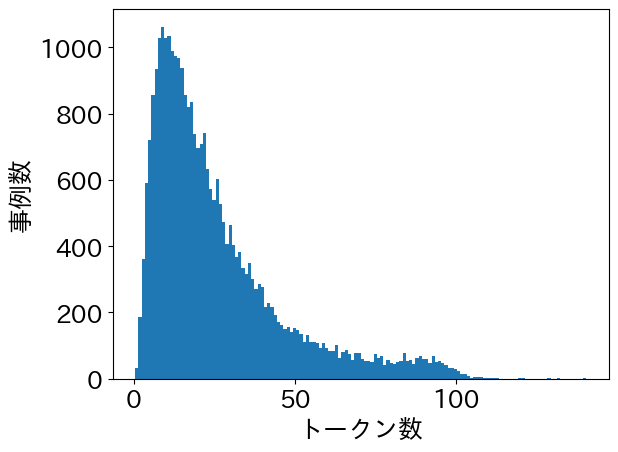

100%|██████████| 2500/2500 [00:01<00:00, 2254.91it/s]


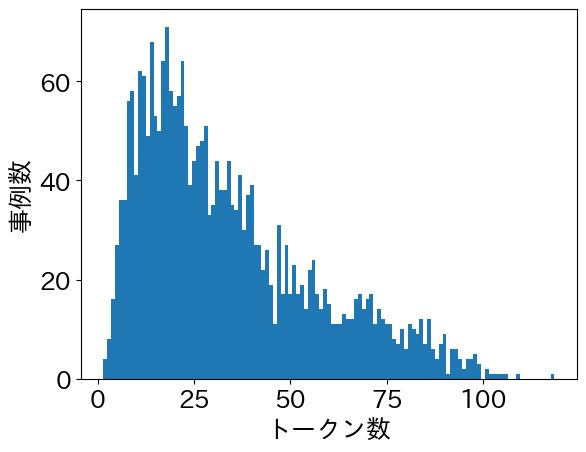

In [12]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

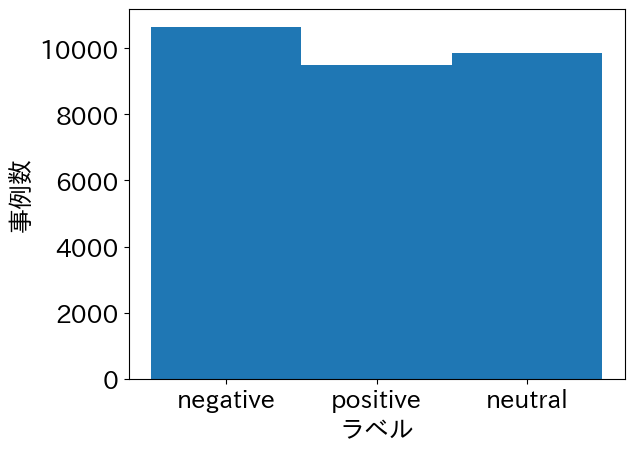

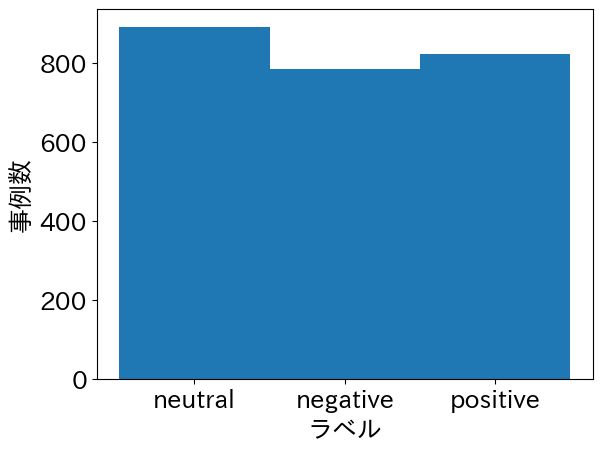

In [23]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_name = get_label(data)
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

### 5.2.5 データセットの前処理

In [31]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = label2id[get_label(example)]
    return encoded_example

In [34]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [35]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


### 5.2.6 ミニバッチ構築

In [36]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [37]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


### 5.2.7 モデルの準備

In [39]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [40]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(1.0375, grad_fn=<NllLossBackward0>), logits=tensor([[-0.2253,  0.2444,  0.3485],
        [-0.0598, -0.0596, -0.2466],
        [-0.1444,  0.1396,  0.1015],
        [-0.2630,  0.3347,  0.3528]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


### 5.2.8 訓練の実行

In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [42]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [43]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.739000,0.605787,0.741600
2,0.506200,0.593323,0.754000
3,0.367200,0.656773,0.755200


TrainOutput(global_step=2814, training_loss=0.5374580280274132, metrics={'train_runtime': 560.8693, 'train_samples_per_second': 160.465, 'train_steps_per_second': 5.017, 'total_flos': 4070216570954688.0, 'train_loss': 0.5374580280274132, 'epoch': 3.0})

### 5.2.9 訓練後のモデルの評価

In [45]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.7552,
 'eval_loss': 0.6567733287811279,
 'eval_runtime': 3.9034,
 'eval_samples_per_second': 640.462,
 'eval_steps_per_second': 20.239}


### 5.2.10 モデルの保存

Google Driveへの保存

In [ ]:
# Googleドライブをマウントする
from google.colab import drive

drive.mount("drive")

In [ ]:
# 保存されたモデルをGoogleドライブのフォルダにコピーする
!mkdir -p drive/MyDrive/llm-book
!cp -r output_marc_ja drive/MyDrive/llm-book

Hugging Face Hubへの保存

In [ ]:
from huggingface_hub import login

login()

In [ ]:
# Hugging Face Hubのリポジトリ名
# "YOUR-ACCOUNT"は自らのユーザ名に置き換えてください
repo_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)